## Importing/Downloading

In [1]:
!wget "https://www.dropbox.com/sh/a0xuhqtlgbez07q/AABllt0-FAVI8lUr9SpJOq4Ga?dl=0"

--2021-05-08 18:39:05--  https://www.dropbox.com/sh/a0xuhqtlgbez07q/AABllt0-FAVI8lUr9SpJOq4Ga?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:601a:18::a27d:712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/a0xuhqtlgbez07q/AABllt0-FAVI8lUr9SpJOq4Ga [following]
--2021-05-08 18:39:06--  https://www.dropbox.com/sh/raw/a0xuhqtlgbez07q/AABllt0-FAVI8lUr9SpJOq4Ga
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucffb1a5235ae46019d9fd143172.dl.dropboxusercontent.com/zip_download_get/AxhYZ5j5E72_HJ6KDuPA8Xi_VxTW2MFTmAGXUzkFXPhsYYrEkED79N5SIe79Fepkrq0QrRTESl4UR7_AwmROhPrVWKqbksm5trnwFCJ_-FkjJw [following]
--2021-05-08 18:39:06--  https://ucffb1a5235ae46019d9fd143172.dl.dropboxusercontent.com/zip_download_get/AxhYZ5j5E72_HJ6KDuPA8Xi_VxTW2MFTmAGXUzkFXPhsYYrEkED79N5SIe79Fepkrq0QrRTESl4UR7_Aw

In [2]:
!unzip "AABllt0-FAVI8lUr9SpJOq4Ga?dl=0"

Archive:  AABllt0-FAVI8lUr9SpJOq4Ga?dl=0
mapname:  conversion of  failed
 extracting: GK2_page-0358_edited.jpg  
 extracting: GK2_page-0358_cropped.jpg  
 extracting: GK2_page-0419_cropped.jpg  
 extracting: GK2_page-0379_cropped.jpg  
 extracting: GK2_page-0345_cropped.jpg  
 extracting: GK2_page-0344_cropped.jpg  
 extracting: GK2_page-0403_cropped.jpg  
 extracting: 2021-05-08_cropped(b).png  
 extracting: 2021-05-08_cropped(a).png  
 extracting: GK2_page-0418_cropped.jpg  
 extracting: GK2_page-0358_cropped(b).jpg  
 extracting: GK2_page-0358_cropped(a).jpg  
 extracting: GK2_page-0366_cropped(b).jpg  
 extracting: GK2_page-0366_cropped(a).jpg  

1 archive had fatal errors.


In [3]:
import cv2
import imutils
from imutils import contours as cont
import numpy as np
from google.colab.patches import cv2_imshow

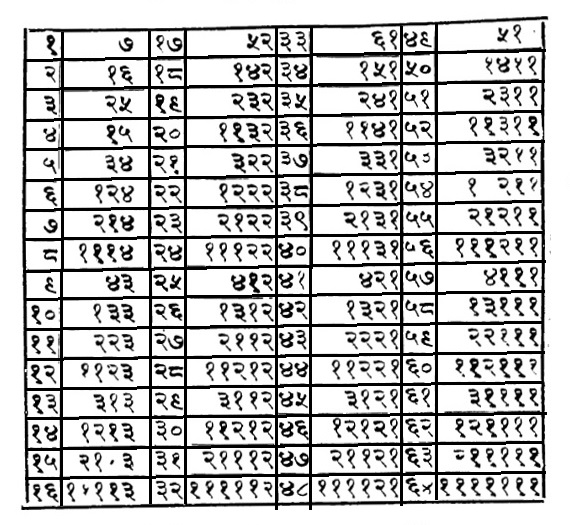

In [4]:
orig = cv2.imread("GK2_page-0358_edited.jpg") # This image is edited using paint
cv2_imshow(orig)

## Image Processing - cell detection

In [5]:
def threshold(image, invert=False):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #Thresholding the image
    thresh, img_bin = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    # Invert the image
    if invert: img_bin = 255-img_bin
    return img_bin

In [6]:
def morph(img_bin, kernel, iterations=3):
    img_temp = cv2.erode(img_bin, kernel, iterations=iterations)
    img_lines = cv2.dilate(img_temp, kernel, iterations=iterations)
    return img_lines

In [7]:
def find_boxes(image):
    #convert binary image
    img_bin = threshold(image, invert=True)

    # Defining a kernel length
    kernel_length = np.array(img_bin).shape[1]//40

    # A verticle kernel of (1 X kernel_length), to detect all the verticle lines.
    verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
    # A horizontal kernel of (kernel_length X 1), to detect all the horizontal lines.
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))

    verticle_lines = morph(img_bin, verticle_kernel)
    horizontal_lines = morph(img_bin, horizontal_kernel)
    print(type(verticle_lines))
    boxes = cv2.add(verticle_lines, horizontal_lines)

    return boxes

In [8]:
def over_draw_boxes(img_bin):
    minLineLength=100
    lines = cv2.HoughLinesP(image=img_bin,rho=1,theta=np.pi/180, threshold=100,lines=np.array([]), minLineLength=minLineLength,maxLineGap=80)
    for i in range(lines.shape[0]):
        cv2.line(img_bin, (lines[i][0][0], lines[i][0][1]), (lines[i][0][2], lines[i][0][3]), (255, 255, 255), 2, cv2.LINE_AA)

    return img_bin

In [9]:
orig.shape

(525, 570, 3)

In [10]:
#resizing image
img = imutils.resize(orig, width=2564)
img_original = img.copy()

In [11]:
boxes = find_boxes(img)
boxes = over_draw_boxes(boxes)

<class 'numpy.ndarray'>


In [12]:
len(boxes)

2361

In [13]:
contours, _ = cv2.findContours(boxes, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [14]:
len(contours)

129

In [15]:
(contours, boundingBoxes) = cont.sort_contours(contours, method="left-to-right")
(contours, boundingBoxes) = cont.sort_contours(contours, method="top-to-bottom")

In [16]:

idx = 0
box_dict = {} # This dict contains bounding box for every cell having key as a number assigned to the cell
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)

    if (w > 20 and h > 10) and w > 1*h:
        #rectangular contours
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        img = cv2.drawContours(img, [box], 0, (0,0,255), 3)


        #cell mappings
        M = cv2.moments(cnt)
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        center = (cx, cy+20)
        if idx!=0:
            cv2.putText(img, str(idx), center, cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 3)
            cv2.imwrite("cropped/0.jpg", img)

        box_dict[idx] = [x,y,h,w]
        #imshow("image", img)
        idx+=1

In [17]:
img =imutils.resize(img,width = 800)

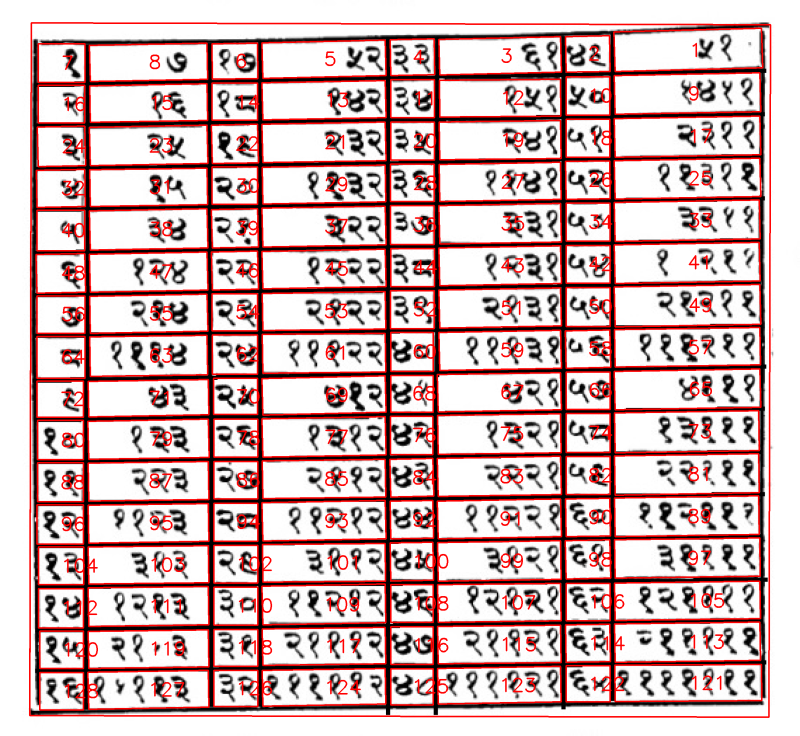

In [18]:
cv2_imshow(img)

In [19]:
box_dict

{0: [96, 79, 2220, 2374],
 1: [1971, 91, 138, 471],
 2: [1814, 115, 117, 141],
 3: [1409, 118, 121, 389],
 4: [1252, 125, 118, 141],
 5: [842, 129, 123, 394],
 6: [680, 139, 115, 147],
 7: [122, 140, 125, 151],
 8: [289, 140, 122, 376],
 9: [1971, 234, 133, 466],
 10: [1814, 246, 124, 141],
 11: [1252, 255, 123, 141],
 12: [1409, 255, 121, 389],
 13: [842, 259, 126, 394],
 14: [680, 267, 120, 147],
 15: [289, 270, 122, 376],
 16: [122, 274, 122, 151],
 17: [1971, 373, 130, 466],
 18: [1814, 382, 123, 141],
 19: [1409, 387, 126, 389],
 20: [1252, 391, 123, 141],
 21: [842, 392, 130, 394],
 22: [680, 399, 126, 147],
 23: [289, 402, 129, 376],
 24: [122, 405, 130, 151],
 25: [1971, 508, 130, 466],
 26: [1814, 517, 123, 142],
 27: [1409, 521, 126, 389],
 28: [1252, 527, 121, 141],
 29: [842, 530, 123, 394],
 30: [680, 536, 121, 147],
 31: [289, 540, 122, 376],
 32: [118, 544, 122, 155],
 33: [1971, 642, 130, 464],
 34: [1814, 651, 123, 142],
 35: [1409, 653, 129, 389],
 36: [1252, 660, 126

## Cropping the table

In [20]:
def extract_table(num1,num2,table_image):

  start_cell = box_dict[num1]
  end_cell = box_dict[num2]

  start_x = start_cell[0]
  start_y = start_cell[1]
  end_x = end_cell[0]+end_cell[3]
  end_y = end_cell[1]+end_cell[2]

  table_image = imutils.resize(table_image,width = 2564)

  ROI = table_image[start_y:end_y, start_x:end_x]    
  # draw the bounding box on the image
  cv2.rectangle(table_image, (start_x, start_y), (end_x, end_y), (0,0,255), 2)
  cv2.imwrite('Extracted_table_'+str(num1)+'_to_'+str(num2)+'.png', ROI)


In [21]:
im_01 = orig.copy()
im_02 = orig.copy()

In [22]:
extract_table(8,60,im_01) # here num1 is the top_left cell number of the desired table
                          # and num2 is the bottom_right cell number of the desired table

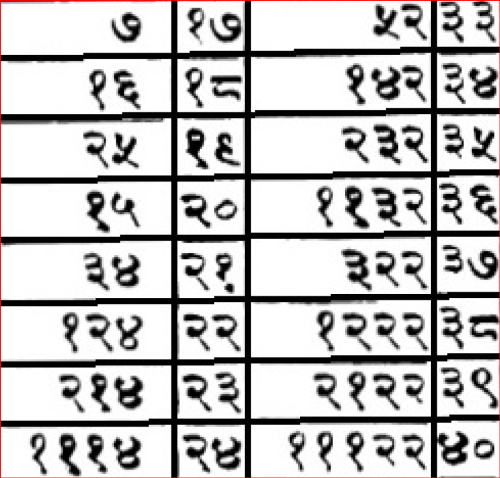

In [23]:
sample=cv2.imread('Extracted_table_8_to_60.png')
sample = imutils.resize(sample,width=500)
cv2_imshow(sample)

In [24]:
extract_table(3,33,im_02)

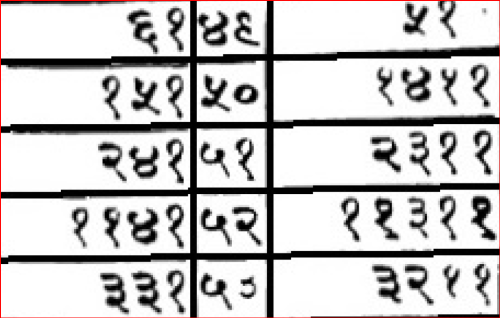

In [25]:
sample_2=cv2.imread('Extracted_table_3_to_33.png')
sample_2 = imutils.resize(sample_2,width=500)
cv2_imshow(sample_2)